In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
import os
from dotenv import load_dotenv

load_dotenv()
PROJECT_ID = os.getenv('GCP_PROJECT_ID')
DATASET_ID = os.getenv('BIGQUERY_DATASET_ID')
client = bigquery.Client()

In [3]:
query = """
WITH players_ba AS (
    SELECT
        batter_name,
        p_throws,
        -- BA
        ROUND(SAFE_DIVIDE(
        COUNTIF(events IN ('single', 'double', 'triple', 'home_run')), -- total hits
        COUNTIF(events NOT IN ('hit_by_pitch', 'walk', 'intent_walk', 'sac_fly', 'sac_bunt', 'catcher_interf') -- total at bats
        )), 3
        ) AS avg_by_p_throws,
    FROM `{PROJECT_ID}.{DATASET_ID}.tbl_statcast_2021_2025_master`
    WHERE events IS NOT NULL
        AND game_type = "R"
        AND batter_name IS NOT NULL
        AND p_throws IN ('R', 'L')
    GROUP BY p_throws, batter_name
    HAVING COUNTIF(events NOT IN ('hit_by_pitch', 'walk', 'intent_walk', 'sac_fly', 'sac_bunt', 'catcher_interf')) >= 200
)
SELECT
    t1.batter_name,
    -- BA against RHP
    MAX(CASE WHEN t1.p_throws = 'R' THEN t1.avg_by_p_throws ELSE NULL END) AS avg_rhp,

    -- BA against LHP
    MAX(CASE WHEN t1.p_throws = 'L' THEN t1.avg_by_p_throws ELSE NULL END) AS avg_lhp,

    -- diff by p_throw types
    (MAX(CASE WHEN t1.p_throws = 'R' THEN t1.avg_by_p_throws ELSE NULL END) - 
    MAX(CASE WHEN t1.p_throws = 'L' THEN t1.avg_by_p_throws ELSE NULL END)) AS diff_vs_p_throws
FROM players_ba t1
GROUP BY t1.batter_name
HAVING diff_vs_p_throws IS NOT NULL
ORDER BY diff_vs_p_throws DESC
"""

In [4]:
df = client.query(query).to_dataframe()

c:\Users\inthe\Desktop\Python_scripts_2025\diamond-lens\venv\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [5]:
df.head()

,batter_name,avg_rhp,avg_lhp,diff_vs_p_throws
0,Michael Brantley,0.330,0.244,0.086
1,Oneil Cruz,0.259,0.175,0.084
2,Jared Walsh,0.258,0.180,0.078
3,Jesús Sánchez,0.260,0.182,0.078
4,Josh Lowe,0.269,0.191,0.078


In [6]:
df.describe()

,avg_rhp,avg_lhp,diff_vs_p_throws
count,397.000000,397.000000,397.000000
mean,0.244564,0.251123,-0.006559
std,0.025514,0.031685,0.033599
min,0.138000,0.164000,-0.116000
25%,0.229000,0.231000,-0.029000
50%,0.245000,0.251000,-0.008000
75%,0.260000,0.273000,0.015000
max,0.330000,0.340000,0.086000


In [8]:
# 独立サンプルt検定
t_stat, p_value = stats.ttest_ind(
    df['avg_rhp'],
    df['avg_lhp']
)
print(f"t-statistic: {t_stat}, p-value: {p_value}")

t-statistic: -3.212642829904647, p-value: 0.0013683750892857414


In [9]:
# 効果量（Cohen's d）計算
def cohens_d(group1, group2):
    # 平均と標準偏差を計算
    mean1 = group1.mean()
    mean2 = group2.mean()
    std1 = group1.std()
    std2 = group2.std()

    # 効果量（Cohen's d）を計算 （サンプルサイズが同じため、プールされた標準偏差を使用）
    pooled_std = ((std1 ** 2 + std2 ** 2) / 2) ** 0.5

    return abs(mean1 - mean2) / pooled_std if pooled_std else 0

effect_size = cohens_d(df['avg_rhp'], df['avg_lhp'])
print(f"Effect size (Cohen's d): {effect_size}")

Effect size (Cohen's d): 0.2280248556045807


In [10]:
# 信頼区間計算 (95% Confidence Interval)
def confidence_interval(data, confidence=0.95) -> tuple:
    """Calculate the confidence interval for the given data."""

    data = np.array(data)

    # sample size
    n = len(data)
    # sample mean
    mean = data.mean()
    # standard error of mean
    std_err = stats.sem(data)

    # ----------------------------------------------------------------------
    # 信頼区間の計算
    # ----------------------------------------------------------------------
    h = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)

    # lower and upper bound of CI
    lower_bound = mean - h
    upper_bound = mean + h

    return lower_bound, upper_bound

# diff between vs. RHP and LHP
diff_data = df['diff_vs_p_throws']

lower_ci, upper_ci = confidence_interval(diff_data)

print(f"95% Confidence Interval: ({lower_ci:.3f}, {upper_ci:.3f})")


95% Confidence Interval: (-0.010, -0.003)


C:\Users\inthe\AppData\Local\Temp\ipykernel_49340\4096218134.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\inthe\AppData\Local\Temp\ipykernel_49340\4096218134.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


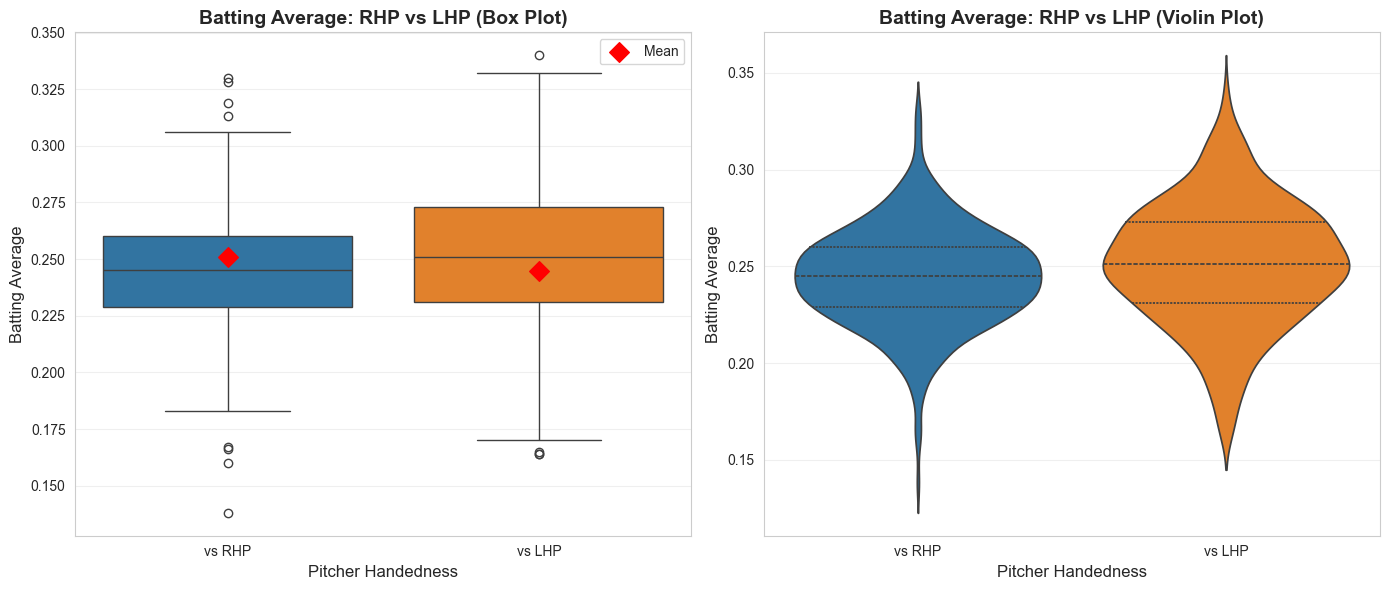


Statistical Summary

【vs RHP】
  Mean: 0.245
  Std:  0.026
  Median: 0.245

【vs LHP】
  Mean: 0.251
  Std:  0.032
  Median: 0.251

【T-test Results】
  t-statistic: -3.213
  p-value: 0.0014
  Effect size (Cohen's d): 0.228
  95% CI of difference: (-0.010, -0.003)

【Conclusion】
  ✅ 統計的有意差あり (p < 0.05)
  → 打者は左投手相手の方が打率が0.007高い
  効果量: 小程度 (0.2 <= d < 0.5)


In [11]:
# Visualization
# セル: 可視化 - ボックスプロット + バイオリンプロット
import matplotlib.pyplot as plt
import seaborn as sns

# スタイル設定
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# データを縦持ちに変換（matplotlibで扱いやすい形式）
df_melted = pd.melt(
    df[['batter_name', 'avg_rhp', 'avg_lhp']], 
    id_vars=['batter_name'],
    value_vars=['avg_rhp', 'avg_lhp'],
    var_name='pitcher_hand',
    value_name='batting_avg'
)

# ラベルをわかりやすく変更
df_melted['pitcher_hand'] = df_melted['pitcher_hand'].map({
    'avg_rhp': 'vs RHP',
    'avg_lhp': 'vs LHP'
})

# サブプロット作成（1行2列）
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --------------------------------------------------
# 左側: ボックスプロット
# --------------------------------------------------
sns.boxplot(
    data=df_melted,
    x='pitcher_hand',
    y='batting_avg',
    palette=['#1f77b4', '#ff7f0e'],
    ax=axes[0]
)

axes[0].set_title('Batting Average: RHP vs LHP (Box Plot)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Pitcher Handedness', fontsize=12)
axes[0].set_ylabel('Batting Average', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# 統計情報を追加（平均値を点で表示）
means = df_melted.groupby('pitcher_hand')['batting_avg'].mean()
positions = [0, 1]
axes[0].scatter(positions, means, color='red', s=100, zorder=3, label='Mean', marker='D')
axes[0].legend()

# --------------------------------------------------
# 右側: バイオリンプロット
# --------------------------------------------------
sns.violinplot(
    data=df_melted,
    x='pitcher_hand',
    y='batting_avg',
    palette=['#1f77b4', '#ff7f0e'],
    inner='quartile',  # 四分位数を表示
    ax=axes[1]
)

axes[1].set_title('Batting Average: RHP vs LHP (Violin Plot)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Pitcher Handedness', fontsize=12)
axes[1].set_ylabel('Batting Average', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

# レイアウト調整
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 統計サマリー表示
# --------------------------------------------------
print("\n" + "="*60)
print("Statistical Summary")
print("="*60)
print(f"\n【vs RHP】")
print(f"  Mean: {df['avg_rhp'].mean():.3f}")
print(f"  Std:  {df['avg_rhp'].std():.3f}")
print(f"  Median: {df['avg_rhp'].median():.3f}")

print(f"\n【vs LHP】")
print(f"  Mean: {df['avg_lhp'].mean():.3f}")
print(f"  Std:  {df['avg_lhp'].std():.3f}")
print(f"  Median: {df['avg_lhp'].median():.3f}")

print(f"\n【T-test Results】")
print(f"  t-statistic: {t_stat:.3f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Effect size (Cohen's d): {effect_size:.3f}")
print(f"  95% CI of difference: ({lower_ci:.3f}, {upper_ci:.3f})")

print(f"\n【Conclusion】")
if p_value < 0.05:
    print(f"  ✅ 統計的有意差あり (p < 0.05)")
    print(f"  → 打者は左投手相手の方が打率が{abs(df['avg_lhp'].mean() - df['avg_rhp'].mean()):.3f}高い")
else:
    print(f"  ❌ 統計的有意差なし (p >= 0.05)")

if effect_size < 0.2:
    print(f"  効果量: 小さい (d < 0.2)")
elif effect_size < 0.5:
    print(f"  効果量: 小程度 (0.2 <= d < 0.5)")
elif effect_size < 0.8:
    print(f"  効果量: 中程度 (0.5 <= d < 0.8)")
else:
    print(f"  効果量: 大きい (d >= 0.8)")
print("="*60)